In [1]:
#Importing essential libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import keras.utils as image

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [ ]:
#Obsolete code block, written for future reference
''''
!pip install PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': 'https://drive.google.com/drive/folders/1vRK-TsBbFiAAqomqFh0G0Q_IIYisK53r?usp=share_link'})
''''

In [2]:
#mounting the google drive to the colab file
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#mounting google drive
import os
os.chdir("/content/gdrive/My Drive/ML Project Group 21/Models")
!ls

model1.h5


In [4]:
#Accessing training data file in train dataframe object
train = pd.read_csv('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/2. Groundtruths/training28.csv')

In [7]:
df = train.drop(['ID'],axis=1).drop([1506,1505,1744,1752,1753,1756,1762,1770,1781,1788,1792,1842,1846,1873,1878])
df.shape

(1905, 29)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


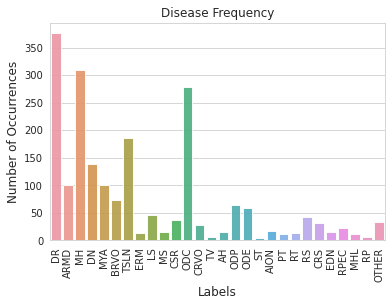

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df.iloc[:, 1:].sum(axis=0)
sns.set_style("whitegrid")
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)
plt.title('Disease Frequency')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show()

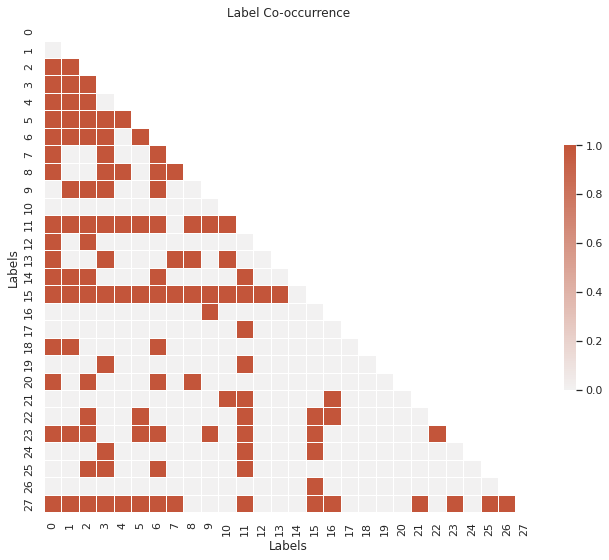

In [10]:
label_matrix = df.iloc[:, 1:].values
label_cooccurrence = np.dot(label_matrix.T, label_matrix)

sns.set(style="white")
mask = np.triu(np.ones_like(label_cooccurrence, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(label_cooccurrence, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Label Co-occurrence')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(type(train), train.shape)

<class 'pandas.core.frame.DataFrame'> (1920, 30)


In [ ]:
display(train)

In [ ]:
print(train['DR'][3:7].astype('str'))

In [ ]:
train.columns

In [ ]:
#Accessing training images and converting into a numpy array of matrices
train_image = []
for i in tqdm(range(train.shape[0])):
  if i not in [1506,1505,1744,1752,1753,1756,1762,1770,1781,1788,1792,1842,1846,1873,1878]:
    img = image.load_img('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/1. Original Images/a. Training Set/'+train['ID'][i].astype('str')+'.png',target_size=(100,100,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1920/1920 [16:27<00:00,  1.94it/s]


In [ ]:
X.shape

(1905, 100, 100, 3)

In [ ]:
#Accessing validation data file in train dataframe object
valid = pd.read_csv('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/2. Groundtruths/validation28.csv')

In [ ]:
print(type(valid), valid.shape)
display(valid)

<class 'pandas.core.frame.DataFrame'> (640, 30)


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
637,638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Accessing training images and converting into a numpy array of matrices
valid_image = []
for i in tqdm(range(valid.shape[0])):
  if i not in [549,550,552,560,590,596]:
    img2 = image.load_img('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/1. Original Images/b. Validation Set/'+valid['ID'][i].astype('str')+'.png',target_size=(100,100,3))
    img2 = image.img_to_array(img2)
    img2 = img2/255
    valid_image.append(img2)
X2 = np.array(valid_image)

100%|██████████| 640/640 [04:20<00:00,  2.45it/s]


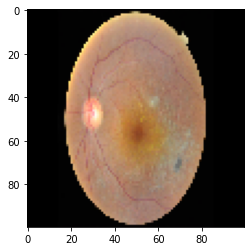

In [ ]:
plt.imshow(X2[2])

In [ ]:
#Finalizing the training and validation sets
X_train = X
X_valid = X2

In [5]:
#Same for label sets and removing the nonexistent images
y_train = np.array(train.drop(['ID','Disease_Risk'],axis=1).drop([1506,1505,1744,1752,1753,1756,1762,1770,1781,1788,1792,1842,1846,1873,1878]))
y_train.shape
display(y_train)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train.shape

(1905, 28)

In [ ]:
y_valid = np.array(valid.drop(['ID','Disease_Risk'],axis=1).drop([549,550,552,560,590,596]))
y_valid.shape

(634, 28)

In [ ]:
#Model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)        0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=64)

Epoch 1/10
30/30 [==============================] - 48s 1s/step - loss: 0.4322 - accuracy: 0.0646 - val_loss: 0.3039 - val_accuracy: 0.0284
Epoch 2/10
30/30 [==============================] - 41s 1s/step - loss: 0.2371 - accuracy: 0.1003 - val_loss: 0.2336 - val_accuracy: 0.0284
Epoch 3/10
30/30 [==============================] - 39s 1s/step - loss: 0.1907 - accuracy: 0.1302 - val_loss: 0.1770 - val_accuracy: 0.4164
Epoch 4/10
30/30 [==============================] - 42s 1s/step - loss: 0.1781 - accuracy: 0.1643 - val_loss: 0.1484 - val_accuracy: 0.4164
Epoch 5/10
30/30 [==============================] - 45s 1s/step - loss: 0.1699 - accuracy: 0.1743 - val_loss: 0.1435 - val_accuracy: 0.4164
Epoch 6/10
30/30 [==============================] - 39s 1s/step - loss: 0.1646 - accuracy: 0.1911 - val_loss: 0.1419 - val_accuracy: 0.4164
Epoch 7/10
30/30 [==============================] - 43s 1s/step - loss: 0.1607 - accuracy: 0.1953 - val_loss: 0.1420 - val_accuracy: 0.4164
Epoch 8/10
30/30 [==

In [ ]:
#Accessing validation data file in train dataframe object
test = pd.read_csv('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/2. Groundtruths/testing28.csv')

In [ ]:
print(type(test), test.shape)
display(test)

<class 'pandas.core.frame.DataFrame'> (640, 30)


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Accessing training images and converting into a numpy array of matrices
test_image = []
for i in tqdm(range(test.shape[0])):
  if i not in [553,590,592,564,614,617,622,624,628]:
    img3 = image.load_img('/content/gdrive/MyDrive/ML Project Group 21/Sample Data /A. RFMiD_All_Classes_Dataset/1. Original Images/c. Testing Set/'+test['ID'][i].astype('str')+'.png',target_size=(100,100,3))
    img3 = image.img_to_array(img3)
    img3 = img3/255
    test_image.append(img3)
X3 = np.array(test_image)

100%|██████████| 640/640 [04:57<00:00,  2.15it/s]


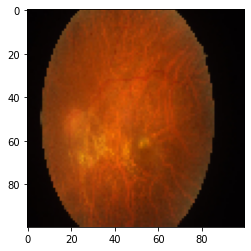

In [ ]:
X_test = X3
plt.imshow(img3)

In [ ]:
y_test = np.array(test.drop(['ID','Disease_Risk'],axis=1).drop([553,590,592,564,614,617,622,624,628]))
y_test.shape
print(y_test)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]]


In [ ]:
classes = np.array(train.columns[2:])
proba = model.predict(X_test[0].reshape(1,100,100,3))
top_3 = np.argsort(proba[0])[:-7:-1]
for i in range(6):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
print(proba)
print(top_3)

1/1 [==============================] - 0s 51ms/step
DR (0.254)
MH (0.211)
ODC (0.191)
TSLN (0.136)
DN (0.0974)
MYA (0.0876)
[[0.2536687  0.08119392 0.21097113 0.09740794 0.08760615 0.05999334
  0.13626267 0.02478536 0.04282    0.02629763 0.0329258  0.1910422
  0.02714455 0.01544248 0.02439936 0.05243232 0.05339451 0.00974547
  0.01966524 0.01740498 0.0162494  0.03791175 0.02619624 0.01692491
  0.02618814 0.01555194 0.01602083 0.03336014]]
[ 0  2 11  6  3  4]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
# make predictions on the testing dataset using your trained model
y_pred_prob = model.predict(X_test)

# round the predicted probabilities to get binary labels
#y_pred = y_pred.round()
y_pred = np.zeros_like(y_pred_prob)
y_pred[y_pred_prob >= 0.1] = 1

from sklearn.metrics import classification_report

# Compute precision, recall, F1-score, and other metrics
report = classification_report(y_test, y_pred, target_names=train.columns[2:])

# Print the report
print(report)


# calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

# calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# calculate hamming loss
hamming = hamming_loss(y_test, y_pred)

#bprint the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Hamming loss:", hamming)

20/20 [==============================] - 6s 291ms/step
              precision    recall  f1-score   support

          DR       0.20      1.00      0.33       124
        ARMD       0.00      0.00      0.00        31
          MH       0.16      1.00      0.28       103
          DN       0.00      0.00      0.00        46
         MYA       0.00      0.00      0.00        32
        BRVO       0.00      0.00      0.00        23
        TSLN       0.08      1.00      0.15        53
         ERM       0.00      0.00      0.00         5
          LS       0.00      0.00      0.00        15
          MS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00        13
         ODC       0.14      1.00      0.25        90
        CRVO       0.00      0.00      0.00         9
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         5
         ODP       0.00      0.00      0.00        24
         ODE       0.00   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = np.zeros_like(y_pred_prob)
y_pred[y_pred_prob >= 0.8] = 1

# Compute accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))


20/20 [==============================] - 8s 350ms/step
Accuracy: 96.22%


In [ ]:
from keras.utils import to_categorical

# Convert binary-encoded labels to multi-hot encoded labels
y_test_multi_hot = to_categorical(y_test, num_classes=28)
y_pred_multi_hot = to_categorical(y_pred, num_classes=28)

# Compute Hamming loss
hamming_loss = np.mean(np.not_equal(y_test_multi_hot, y_pred_multi_hot))
print("Hamming loss: {:.2f}%".format(hamming_loss * 100))

Hamming loss: 0.27%


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_test, y_pred)

# print the confusion matrix for each label
for i in range(len(cm)):
    print("Confusion matrix for label", i)
    print(cm[i])

Confusion matrix for label 0
[[507   0]
 [124   0]]
Confusion matrix for label 1
[[600   0]
 [ 31   0]]
Confusion matrix for label 2
[[528   0]
 [103   0]]
Confusion matrix for label 3
[[585   0]
 [ 46   0]]
Confusion matrix for label 4
[[599   0]
 [ 32   0]]
Confusion matrix for label 5
[[608   0]
 [ 23   0]]
Confusion matrix for label 6
[[578   0]
 [ 53   0]]
Confusion matrix for label 7
[[626   0]
 [  5   0]]
Confusion matrix for label 8
[[616   0]
 [ 15   0]]
Confusion matrix for label 9
[[624   0]
 [  7   0]]
Confusion matrix for label 10
[[618   0]
 [ 13   0]]
Confusion matrix for label 11
[[541   0]
 [ 90   0]]
Confusion matrix for label 12
[[622   0]
 [  9   0]]
Confusion matrix for label 13
[[629   0]
 [  2   0]]
Confusion matrix for label 14
[[626   0]
 [  5   0]]
Confusion matrix for label 15
[[607   0]
 [ 24   0]]
Confusion matrix for label 16
[[614   0]
 [ 17   0]]
Confusion matrix for label 17
[[629   0]
 [  2   0]]
Confusion matrix for label 18
[[627   0]
 [  4   0]]
Con

In [ ]:
# # y_true and y_pred are your true and predicted labels, respectively
# cm = multilabel_confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# fig, ax = plt.subplots()
# im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# ax.figure.colorbar(im, ax=ax)

# # Set the axis labels
# ax.set(xticks=np.arange(cm.shape[1]),
#        yticks=np.arange(cm.shape[0]),
#        xticklabels=classes, yticklabels=classes,
#        xlabel='Predicted label',
#        ylabel='True label')

# # Rotate the tick labels and set their alignment
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations
# fmt = '.2f' # Set the format of the text annotations
# thresh = cm.max() / 2. # Set the threshold for the text color
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         ax.text(j, i, format(cm[i, j], fmt),
#                 ha="center", va="center",
#                 color="white" if cm[i, j] > thresh else "black")
# fig.tight_layout()
# plt.show()

In [ ]:
model.save('model1.h5')

In [ ]:
acc = np.zeros((8, 3))
los = np.zeros((8, 3))
accu = loss =[]
bch = [16,32,64]
epo= [5,10,20,30,50,75,100,150]

for i in range(3):
  accu = loss =[]
  for j in range(8):
    model.fit(X_train, y_train, epochs=epo[j], validation_data=(X_valid, y_valid), batch_size=bch[i])
  
    y_pred_prob = model.predict(X_test)
    y_pred = np.zeros_like(y_pred_prob)
    y_pred[y_pred_prob >= 0.8] = 1
    accuracy = np.mean(y_pred == y_test)
    acc[i, j] = accuracy*100
    accu.append(accuracy*100)

    y_test_multi_hot = to_categorical(y_test, num_classes=28)
    y_pred_multi_hot = to_categorical(y_pred, num_classes=28)
    hamming_loss = np.mean(np.not_equal(y_test_multi_hot, y_pred_multi_hot))
    los[i, j] = hamming_loss * 100
    loss.append(hamming_loss * 100)

  plt.plot(epo,accu)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.title("batch size = ", bch[i])
  plt.figure()
  plt.plot(epo,loss)
  plt.xlabel("epochs")
  plt.ylabel("Hamming-Loss")
  plt.title("batch size = ", bch[i])
  plt.figure()

for i in range(3):
  accu = []
  for j in range(8):
    accu.append(acc[i, j])
  plt.plot(epo,accu, label = str(bch[i]))
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
    
plt.figure()

for i in range(3):
  loss = []
  for j in range(8):
    loss.append(los[i, j])
  plt.plot(epo,loss, label= str(bch[i]))
  plt.xlabel("epochs")
  plt.ylabel("Hamming-Loss")

plt.figure()

Epoch 1/5
120/120 [==============================] - 40s 335ms/step - loss: 0.1509 - accuracy: 0.2693 - val_loss: 0.1394 - val_accuracy: 0.4164
Epoch 2/5
120/120 [==============================] - 43s 357ms/step - loss: 0.1484 - accuracy: 0.2682 - val_loss: 0.1397 - val_accuracy: 0.4164
Epoch 3/5
120/120 [==============================] - 40s 330ms/step - loss: 0.1466 - accuracy: 0.2814 - val_loss: 0.1391 - val_accuracy: 0.4164
Epoch 4/5
120/120 [==============================] - 43s 358ms/step - loss: 0.1455 - accuracy: 0.2861 - val_loss: 0.1395 - val_accuracy: 0.4211
Epoch 5/5
20/20 [==============================] - 3s 143ms/step
Epoch 1/10
120/120 [==============================] - 40s 336ms/step - loss: 0.1447 - accuracy: 0.3344 - val_loss: 0.1398 - val_accuracy: 0.4164
Epoch 2/10
120/120 [==============================] - 40s 338ms/step - loss: 0.1445 - accuracy: 0.2966 - val_loss: 0.1422 - val_accuracy: 0.4164
Epoch 3/10
120/120 [==============================] - 42s 346ms/step 

IndexError: ignored

In [ ]:
epo=[50,75,100]
for epos in epo:
  model.fit(X_train, y_train, epochs=epos, validation_data=(X_valid, y_valid), batch_size=64)
  
  y_pred_prob = model.predict(X_test)
  y_pred = np.zeros_like(y_pred_prob)
  y_pred[y_pred_prob >= 0.8] = 1
  accuracy = np.mean(y_pred == y_test)
  acc.append(accuracy*100)

  y_test_multi_hot = to_categorical(y_test, num_classes=28)
  y_pred_multi_hot = to_categorical(y_pred, num_classes=28)
  hamming_loss = np.mean(np.not_equal(y_test_multi_hot, y_pred_multi_hot))
  los.append(hamming_loss * 100)


Epoch 1/50
30/30 [==============================] - 42s 1s/step - loss: 0.1250 - accuracy: 0.3790 - val_loss: 0.1279 - val_accuracy: 0.3281
Epoch 2/50
30/30 [==============================] - 42s 1s/step - loss: 0.1249 - accuracy: 0.3832 - val_loss: 0.1277 - val_accuracy: 0.3297
Epoch 3/50
30/30 [==============================] - 42s 1s/step - loss: 0.1242 - accuracy: 0.3869 - val_loss: 0.1297 - val_accuracy: 0.3896
Epoch 4/50
30/30 [==============================] - 40s 1s/step - loss: 0.1248 - accuracy: 0.3669 - val_loss: 0.1319 - val_accuracy: 0.3155
Epoch 5/50
30/30 [==============================] - 41s 1s/step - loss: 0.1237 - accuracy: 0.3759 - val_loss: 0.1278 - val_accuracy: 0.3486
Epoch 6/50
30/30 [==============================] - 40s 1s/step - loss: 0.1219 - accuracy: 0.3885 - val_loss: 0.1280 - val_accuracy: 0.3297
Epoch 7/50
30/30 [==============================] - 42s 1s/step - loss: 0.1209 - accuracy: 0.3790 - val_loss: 0.1324 - val_accuracy: 0.3849
Epoch 8/50
30/30 [==

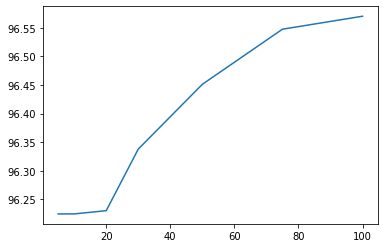

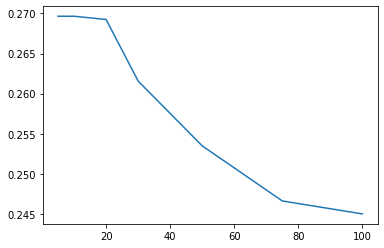

In [ ]:
epo=[5,10,20,30,50,75,100]
plt.plot(epo,acc)
plt.figure()
plt.plot(epo,los)